<a href="https://colab.research.google.com/github/bimarshak7/GAN-image-restore/blob/main/Image_Inpainting_PatchGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#snippet to mount drive and copy kaggle API keys
# place you kaggle keys at MyDrive/Colab Notebooks/ as kaggle.json
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bharatadhikari/humanface8000
! unzip -q *.zip

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F

from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
transform = transforms.Compose([
   transforms.ToPILImage(),
    transforms.Resize((256,256),antialias=True),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.45, 0.43, 0.40], std=[0.24, 0.24, 0.24]),
])

In [ ]:
class ImageDataset(Dataset):
  def __init__(self,dir,transform=None):
    self.img_dir = dir
    self.transform = transform
    self.images = os.listdir(self.img_dir+"color")


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path_org = os.path.join(self.img_dir+"color",self.images[idx])
    img_path_filt = os.path.join(self.img_dir+"gray",self.images[idx])

    image_raw = read_image(img_path_org)
    image_filt = read_image(img_path_filt)

    image_raw =  self.transform(image_raw)
    image_filt = self.transform(image_filt)

    if image_raw.shape[0]==1:
        image_raw = torch.cat([image_raw,image_raw,image_raw])
    return (image_raw,image_filt)

  def see_random(self,n):
    """
      Vizualize random images from custom dataset
      n: number of rows to show
      c: nubmer of columns per row
    """

    figure = plt.figure(figsize=(8, 8))
    idxs = torch.randint(1,len(self.images),(n*2,))
    for i in range(1,len(idxs)+1,2):
      # print("Path",os.path.join(self.img_dir,self.images[idxs[i-1]]))
      img_raw = os.path.join(self.img_dir+"color",self.images[idxs[i-1]])
      img_filt = os.path.join(self.img_dir+"gray",self.images[idxs[i-1]])

      image_raw = read_image(img_raw)
      image_filt = read_image(img_filt)

      image_raw = self.transform(image_raw)
      image_filt = self.transform(image_filt)
      figure.add_subplot(n, 2, i)
      if image_raw.shape[0]==1:
        image_raw = torch.cat([image_raw,image_raw,image_raw])
      plt.imshow(image_raw.squeeze().permute(1,2,0))
      plt.title("Original Image")

      figure.add_subplot(n, 2, i+1)
      plt.imshow(image_filt.permute(1,2,0))
      plt.title("Processed Image")

    plt.show()

In [ ]:
path = "humanface8000/landscape Images/"

In [ ]:
dataset = ImageDataset(path,transform)

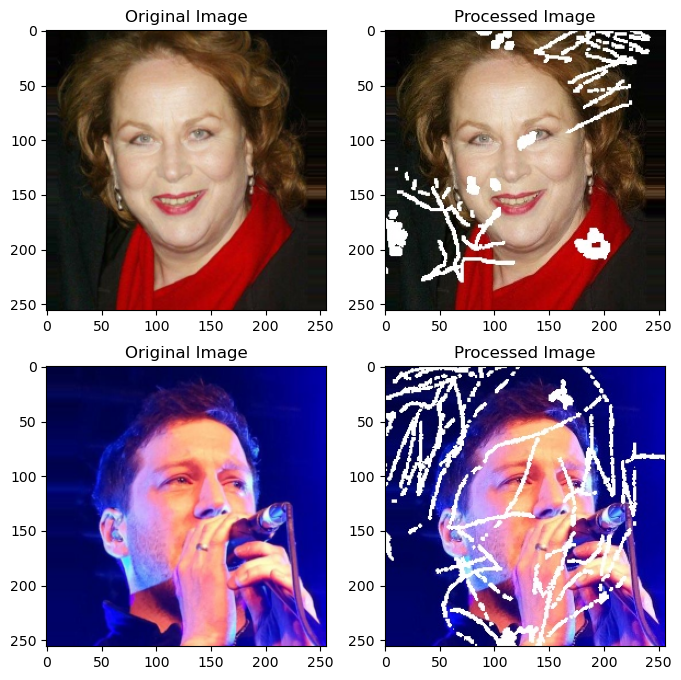

In [ ]:
dataset.see_random(2)

In [ ]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_loader =  DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
class DownSampleConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

In [ ]:
class UpSampleConv(nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel=4,
        strides=2,
        padding=1,
        activation=True,
        batchnorm=True,
        dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [ ]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels):
        """
        Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()

        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(in_channels, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]

        # decoder/upsample convs
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        return self.tanh(x)

In [ ]:
class PatchGAN(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.d1 = DownSampleConv(input_channels, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn

In [ ]:
def display_progress(cond, fake, real, figsize=(10,5)):
    cond = cond.detach().cpu().permute(1, 2, 0)
    fake = fake.detach().cpu().permute(1, 2, 0)
    real = real.detach().cpu().permute(1, 2, 0)

    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(cond)
    ax[0].set_title("Input Image")
    ax[2].imshow(fake)
    ax[1].set_title("Ground Truth")
    ax[2].set_title("Predicted Image")
    ax[1].imshow(real)
    plt.show()

In [ ]:
from tqdm.notebook import tqdm

  0%|          | 0/205 [00:00<?, ?it/s]

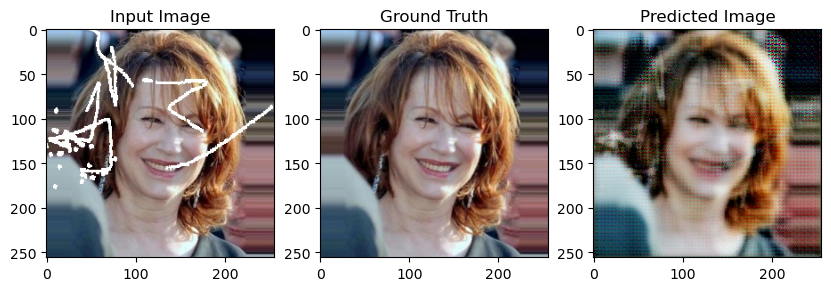

  0%|          | 0/205 [00:00<?, ?it/s]

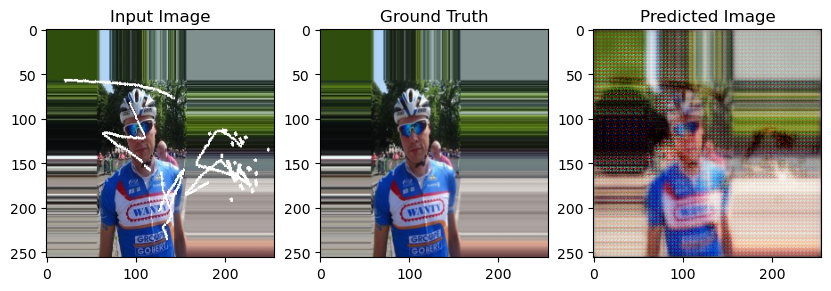

  0%|          | 0/205 [00:00<?, ?it/s]

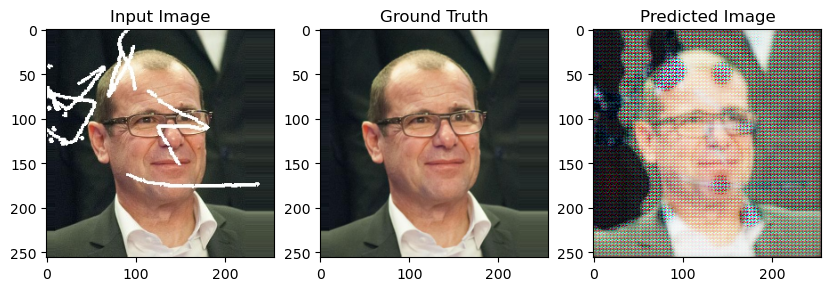

  0%|          | 0/205 [00:00<?, ?it/s]

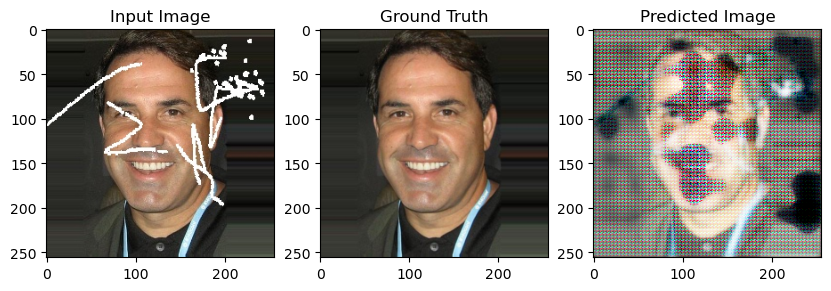

  0%|          | 0/205 [00:00<?, ?it/s]

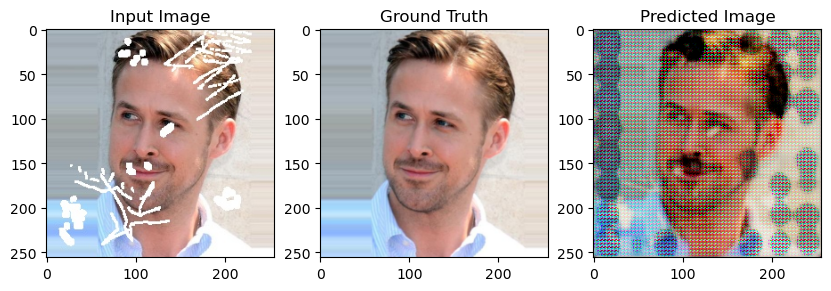

  0%|          | 0/205 [00:00<?, ?it/s]

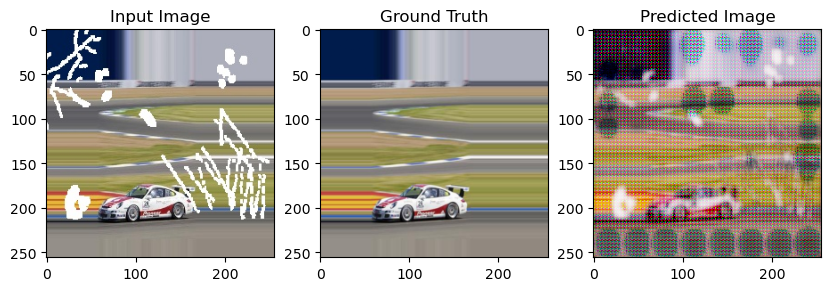

  0%|          | 0/205 [00:00<?, ?it/s]

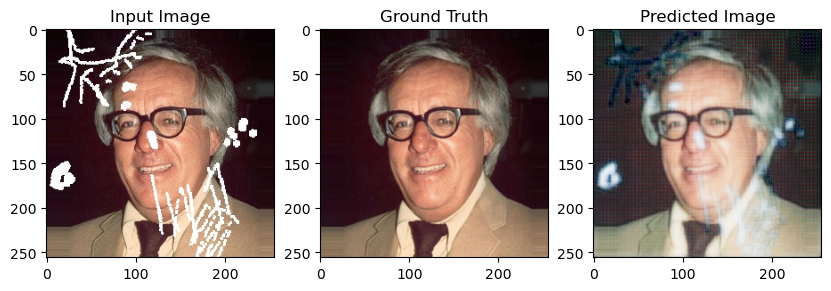

  0%|          | 0/205 [00:00<?, ?it/s]

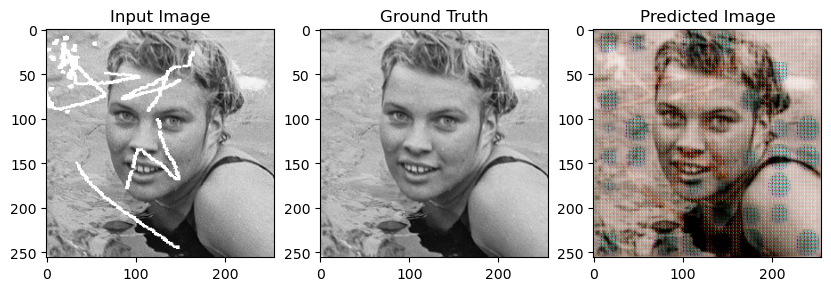

  0%|          | 0/205 [00:00<?, ?it/s]

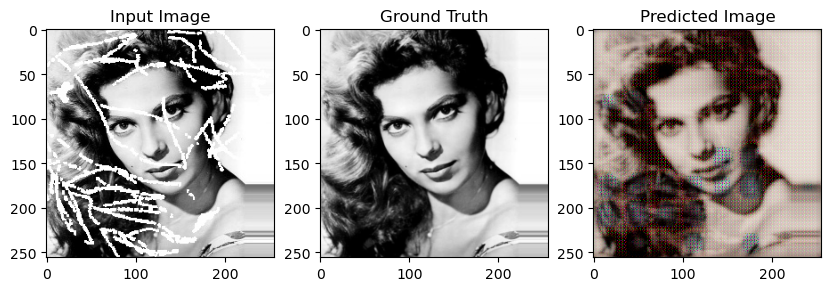

  0%|          | 0/205 [00:00<?, ?it/s]

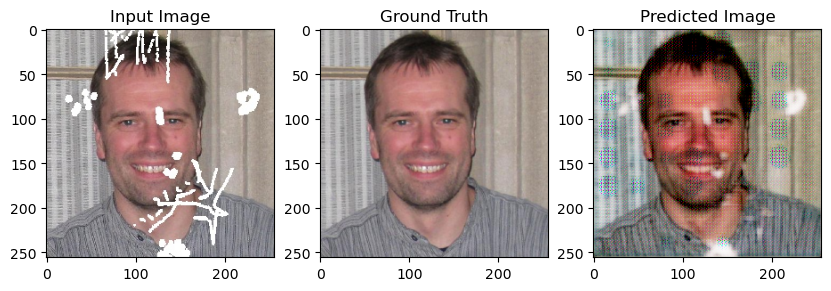

  0%|          | 0/205 [00:00<?, ?it/s]

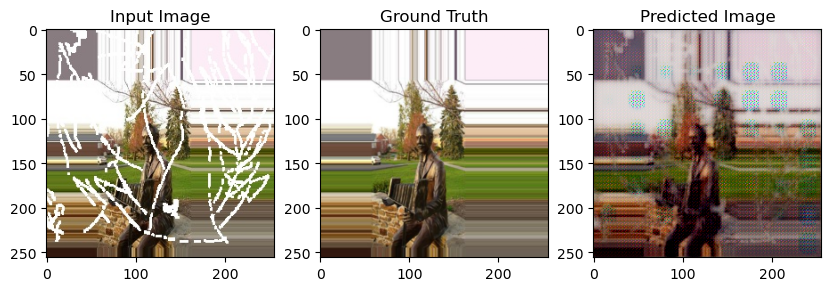

  0%|          | 0/205 [00:00<?, ?it/s]

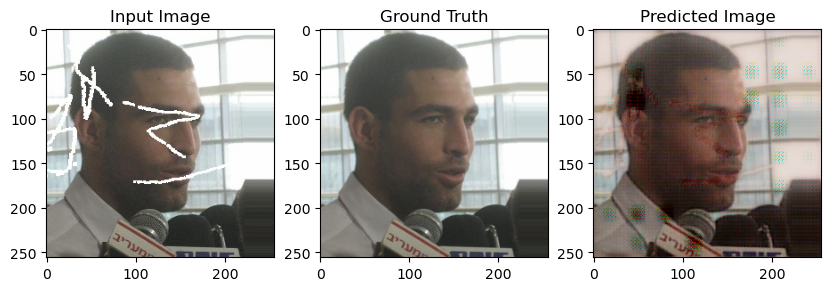

  0%|          | 0/205 [00:00<?, ?it/s]

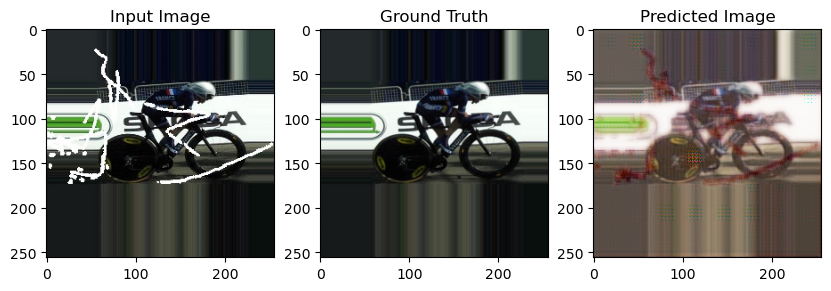

  0%|          | 0/205 [00:00<?, ?it/s]

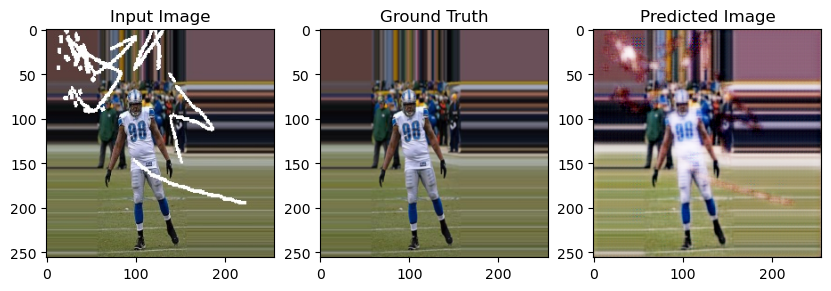

  0%|          | 0/205 [00:00<?, ?it/s]

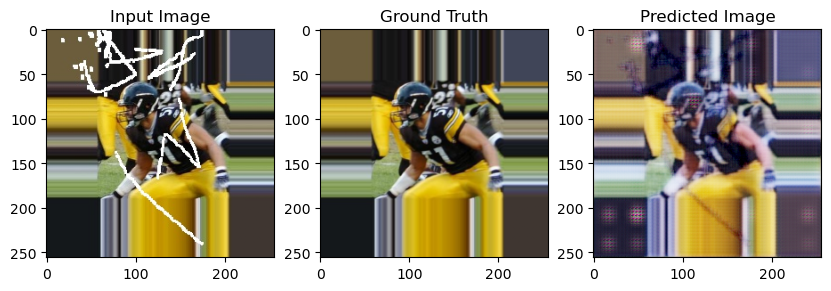

  0%|          | 0/205 [00:00<?, ?it/s]

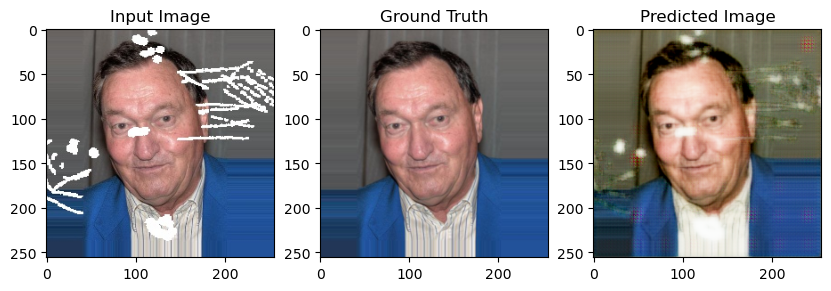

  0%|          | 0/205 [00:00<?, ?it/s]

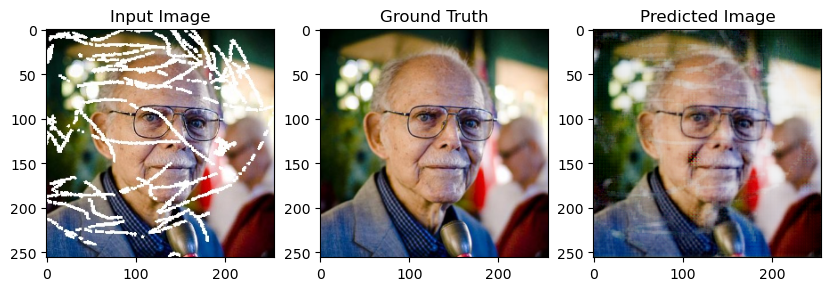

  0%|          | 0/205 [00:00<?, ?it/s]

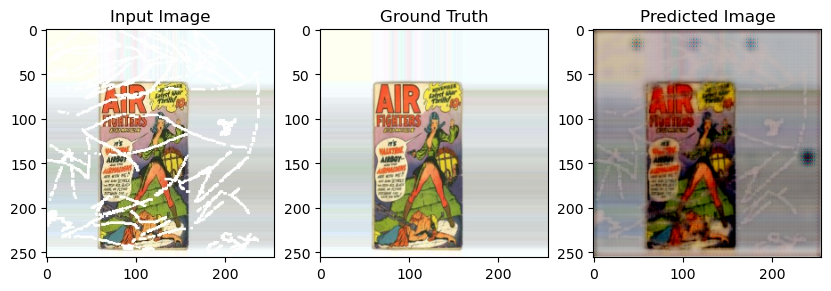

  0%|          | 0/205 [00:00<?, ?it/s]

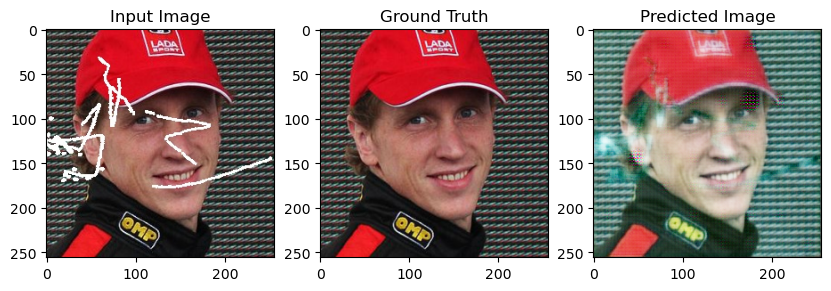

  0%|          | 0/205 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Training setup
def train_GAN(discriminator, generator, dataloader, num_epochs=100, batch_size=64, lr=0.0002):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    discriminator = discriminator.to(device)
    generator = generator.to(device)

    adver_criterion = nn.BCEWithLogitsLoss()
    recon_criterion = nn.L1Loss()
    lambda_recon = 200

    display_step = 100
    lr = 0.0002
    target_size = 256

    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        pbar = tqdm(dataloader)
        for batch_idx, (real_images,noise_images) in enumerate(pbar):
            real_images = real_images.to(device)
            noise_images = noise_images.to(device)
            batch_size = real_images.size(0)

            # Train discriminator
            d_optimizer.zero_grad()

            fake_images = generator(noise_images)
            fake_outputs = discriminator(fake_images,noise_images)

            real_outputs = discriminator(real_images,noise_images)



            real_loss = adver_criterion(real_outputs, torch.zeros_like(fake_outputs))
            fake_loss = adver_criterion(fake_outputs, torch.ones_like(real_outputs))

            d_loss = (real_loss + fake_loss)/2
            d_loss.backward()
            d_optimizer.step()

            # Train generator
            g_optimizer.zero_grad()

            fake_images = generator(noise_images)
            outputs = discriminator(fake_images,noise_images)
            g_loss = adver_criterion(outputs, torch.ones_like(outputs))

            recon_loss = recon_criterion(fake_images, real_images)
            total_loss = g_loss + lambda_recon * recon_loss

            total_loss.backward()
            g_optimizer.step()

            pbar.set_description('Epoch [{}/{}], Step [{}/{}], Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'
                      .format(epoch+1, num_epochs, batch_idx+1, len(dataloader), d_loss.item(), g_loss.item()))
            if (batch_idx+1)%200==0:
                fake = generator(noise_images[0].unsqueeze(0)).detach()
                display_progress(noise_images[0], fake[0], real_images[0])
#init generator and discriminator
gen = Generator(3,3)
dis = PatchGAN(3*2)
# Train the GAN
train_GAN(dis, gen, train_loader, num_epochs=20)

In [ ]:
gen = Generator(3,3)

In [ ]:
gen.load_state_dict(torch.load('/kaggle/input/model-disc/gen_model.pth'))

<All keys matched successfully>

In [ ]:
# torch.save(gen.state_dict(), 'gen_model.pth')
# torch.save(dis.state_dict(), 'dis_model.pth')

In [ ]:
from torchvision.transforms import functional as F2

In [ ]:
def pred(img,tran):
  dog = read_image(img)

  dog_noise = tran(dog)
  dog_n = dog_noise#.cuda()
  dog_n = dog_n.unsqueeze(0)

  clear = gen(dog_n)
  # clear = F.unnormalize(mean=[0.45, 0.43, 0.40], std=[0.24, 0.24, 0.24]),

  show = clear.cpu().squeeze()

  disp = F2.to_pil_image(clear.squeeze())

  plt.figure(figsize=(15,10))


  plt.subplot(1,2,1)
  plt.imshow(transforms.Resize((256,256),antialias=True)(dog).permute(1,2,0))
  plt.title("Raw Image")
  plt.axis("off")


  plt.subplot(1,2,2)
  plt.imshow(disp)
  plt.title("Output Image")
  plt.axis("off")

  # plt.savefig(img.split(".")[0]+"_pred.jpg")